<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:14:47] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


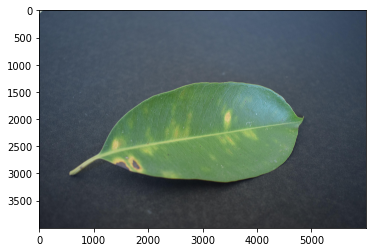

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

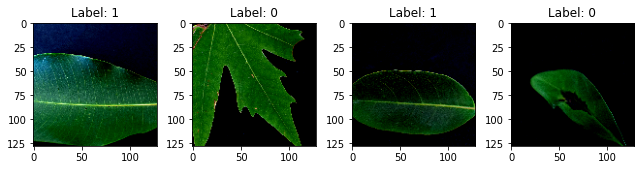

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:14:53] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:14:55] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.256364564939665 samples/sec                   batch loss = 0.5751815438270569 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2694271224893254 samples/sec                   batch loss = 0.8032293319702148 | accuracy = 0.425


Epoch[1] Batch[15] Speed: 1.2710872993973985 samples/sec                   batch loss = 1.8864320516586304 | accuracy = 0.48333333333333334


Epoch[1] Batch[20] Speed: 1.251336086331755 samples/sec                   batch loss = 0.7311415076255798 | accuracy = 0.5125


Epoch[1] Batch[25] Speed: 1.2424555143038285 samples/sec                   batch loss = 1.2163524627685547 | accuracy = 0.52


Epoch[1] Batch[30] Speed: 1.2682685737495447 samples/sec                   batch loss = 0.4529113173484802 | accuracy = 0.5583333333333333


Epoch[1] Batch[35] Speed: 1.223339533198836 samples/sec                   batch loss = 1.2948087453842163 | accuracy = 0.55


Epoch[1] Batch[40] Speed: 1.2673340083497782 samples/sec                   batch loss = 1.0306363105773926 | accuracy = 0.5625


Epoch[1] Batch[45] Speed: 1.2658124359774015 samples/sec                   batch loss = 0.7377599477767944 | accuracy = 0.5444444444444444


Epoch[1] Batch[50] Speed: 1.2687088858388442 samples/sec                   batch loss = 0.6724643707275391 | accuracy = 0.56


Epoch[1] Batch[55] Speed: 1.2682179540975567 samples/sec                   batch loss = 0.8238474130630493 | accuracy = 0.5590909090909091


Epoch[1] Batch[60] Speed: 1.269307744039373 samples/sec                   batch loss = 0.5878581404685974 | accuracy = 0.5541666666666667


Epoch[1] Batch[65] Speed: 1.2671010367331463 samples/sec                   batch loss = 0.5509900450706482 | accuracy = 0.5807692307692308


Epoch[1] Batch[70] Speed: 1.26694602503351 samples/sec                   batch loss = 0.3275081515312195 | accuracy = 0.5964285714285714


Epoch[1] Batch[75] Speed: 1.2665158271297983 samples/sec                   batch loss = 1.5843708515167236 | accuracy = 0.6066666666666667


Epoch[1] Batch[80] Speed: 1.2685913690470565 samples/sec                   batch loss = 1.0831654071807861 | accuracy = 0.603125


Epoch[1] Batch[85] Speed: 1.2653387254657584 samples/sec                   batch loss = 0.515549898147583 | accuracy = 0.6088235294117647


Epoch[1] Batch[90] Speed: 1.2698376752513512 samples/sec                   batch loss = 0.3731088936328888 | accuracy = 0.6083333333333333


Epoch[1] Batch[95] Speed: 1.2665511080424319 samples/sec                   batch loss = 0.45222750306129456 | accuracy = 0.618421052631579


Epoch[1] Batch[100] Speed: 1.265383961817378 samples/sec                   batch loss = 0.1561196893453598 | accuracy = 0.6275


Epoch[1] Batch[105] Speed: 1.268641730720516 samples/sec                   batch loss = 0.5668562054634094 | accuracy = 0.6309523809523809


Epoch[1] Batch[110] Speed: 1.2655135809198281 samples/sec                   batch loss = 0.7410844564437866 | accuracy = 0.6318181818181818


Epoch[1] Batch[115] Speed: 1.269303422634089 samples/sec                   batch loss = 0.7659205198287964 | accuracy = 0.6369565217391304


Epoch[1] Batch[120] Speed: 1.269689584305183 samples/sec                   batch loss = 0.5157442688941956 | accuracy = 0.6416666666666667


Epoch[1] Batch[125] Speed: 1.270815884804678 samples/sec                   batch loss = 0.3635530471801758 | accuracy = 0.652


Epoch[1] Batch[130] Speed: 1.2625620370386397 samples/sec                   batch loss = 0.38978639245033264 | accuracy = 0.6557692307692308


Epoch[1] Batch[135] Speed: 1.2680206910620015 samples/sec                   batch loss = 0.9204691052436829 | accuracy = 0.6555555555555556


Epoch[1] Batch[140] Speed: 1.2646002273040082 samples/sec                   batch loss = 0.4571097493171692 | accuracy = 0.6589285714285714


Epoch[1] Batch[145] Speed: 1.270603186047401 samples/sec                   batch loss = 1.1876956224441528 | accuracy = 0.653448275862069


Epoch[1] Batch[150] Speed: 1.2663588556798222 samples/sec                   batch loss = 0.6233416199684143 | accuracy = 0.65


Epoch[1] Batch[155] Speed: 1.2758122809020045 samples/sec                   batch loss = 0.8547190427780151 | accuracy = 0.646774193548387


Epoch[1] Batch[160] Speed: 1.269419054372535 samples/sec                   batch loss = 0.44131022691726685 | accuracy = 0.6484375


Epoch[1] Batch[165] Speed: 1.2681574650783092 samples/sec                   batch loss = 0.17069114744663239 | accuracy = 0.6530303030303031


Epoch[1] Batch[170] Speed: 1.2611318996038576 samples/sec                   batch loss = 0.8742496967315674 | accuracy = 0.6485294117647059


Epoch[1] Batch[175] Speed: 1.2699887809135186 samples/sec                   batch loss = 0.5216628313064575 | accuracy = 0.6471428571428571


Epoch[1] Batch[180] Speed: 1.265815874109038 samples/sec                   batch loss = 0.3709415793418884 | accuracy = 0.6472222222222223


Epoch[1] Batch[185] Speed: 1.2580945912677497 samples/sec                   batch loss = 0.6552244424819946 | accuracy = 0.6513513513513514


Epoch[1] Batch[190] Speed: 1.2612213008566828 samples/sec                   batch loss = 0.8097767233848572 | accuracy = 0.65


Epoch[1] Batch[195] Speed: 1.2634742556785008 samples/sec                   batch loss = 0.8295621871948242 | accuracy = 0.6525641025641026


Epoch[1] Batch[200] Speed: 1.270251859755158 samples/sec                   batch loss = 0.7023836374282837 | accuracy = 0.65375


Epoch[1] Batch[205] Speed: 1.2674771455515994 samples/sec                   batch loss = 0.8258693218231201 | accuracy = 0.6560975609756098


Epoch[1] Batch[210] Speed: 1.260787022470006 samples/sec                   batch loss = 0.5376605987548828 | accuracy = 0.655952380952381


Epoch[1] Batch[215] Speed: 1.2698368102461197 samples/sec                   batch loss = 0.40890610218048096 | accuracy = 0.6569767441860465


Epoch[1] Batch[220] Speed: 1.2709001177936603 samples/sec                   batch loss = 0.5466006994247437 | accuracy = 0.6556818181818181


Epoch[1] Batch[225] Speed: 1.2675789410378253 samples/sec                   batch loss = 0.4640195071697235 | accuracy = 0.6555555555555556


Epoch[1] Batch[230] Speed: 1.2669848700830488 samples/sec                   batch loss = 1.0470669269561768 | accuracy = 0.658695652173913


Epoch[1] Batch[235] Speed: 1.2753301851724879 samples/sec                   batch loss = 0.35621321201324463 | accuracy = 0.6606382978723404


Epoch[1] Batch[240] Speed: 1.2693012139271955 samples/sec                   batch loss = 0.7973180413246155 | accuracy = 0.6614583333333334


Epoch[1] Batch[245] Speed: 1.2712219424766786 samples/sec                   batch loss = 0.32088518142700195 | accuracy = 0.6653061224489796


Epoch[1] Batch[250] Speed: 1.274813677631681 samples/sec                   batch loss = 0.765465259552002 | accuracy = 0.661


Epoch[1] Batch[255] Speed: 1.2684079904214014 samples/sec                   batch loss = 0.7742622494697571 | accuracy = 0.6607843137254902


Epoch[1] Batch[260] Speed: 1.270775360682109 samples/sec                   batch loss = 0.35251757502555847 | accuracy = 0.6653846153846154


Epoch[1] Batch[265] Speed: 1.2608107095611838 samples/sec                   batch loss = 0.387235552072525 | accuracy = 0.6669811320754717


Epoch[1] Batch[270] Speed: 1.270848517746277 samples/sec                   batch loss = 0.7177508473396301 | accuracy = 0.6694444444444444


Epoch[1] Batch[275] Speed: 1.2688481114508796 samples/sec                   batch loss = 0.6921142339706421 | accuracy = 0.6672727272727272


Epoch[1] Batch[280] Speed: 1.2709995752278198 samples/sec                   batch loss = 0.45674315094947815 | accuracy = 0.6660714285714285


Epoch[1] Batch[285] Speed: 1.2678796348293697 samples/sec                   batch loss = 0.4159490764141083 | accuracy = 0.6657894736842105


Epoch[1] Batch[290] Speed: 1.267846291882616 samples/sec                   batch loss = 0.21686196327209473 | accuracy = 0.6689655172413793


Epoch[1] Batch[295] Speed: 1.265940518991957 samples/sec                   batch loss = 0.8300405144691467 | accuracy = 0.6669491525423729


Epoch[1] Batch[300] Speed: 1.2657488339107983 samples/sec                   batch loss = 0.5884024500846863 | accuracy = 0.6658333333333334


Epoch[1] Batch[305] Speed: 1.2717459542595777 samples/sec                   batch loss = 0.4469660818576813 | accuracy = 0.6680327868852459


Epoch[1] Batch[310] Speed: 1.2673866637618199 samples/sec                   batch loss = 1.096383810043335 | accuracy = 0.667741935483871


Epoch[1] Batch[315] Speed: 1.267649144440402 samples/sec                   batch loss = 0.5698768496513367 | accuracy = 0.6658730158730158


Epoch[1] Batch[320] Speed: 1.2662812447119456 samples/sec                   batch loss = 0.3235567510128021 | accuracy = 0.66640625


Epoch[1] Batch[325] Speed: 1.2655886155972491 samples/sec                   batch loss = 0.8342916369438171 | accuracy = 0.6661538461538462


Epoch[1] Batch[330] Speed: 1.2692973727161245 samples/sec                   batch loss = 0.3958796262741089 | accuracy = 0.6666666666666666


Epoch[1] Batch[335] Speed: 1.270312741109856 samples/sec                   batch loss = 0.3334203362464905 | accuracy = 0.6671641791044776


Epoch[1] Batch[340] Speed: 1.2705106217697606 samples/sec                   batch loss = 0.28354397416114807 | accuracy = 0.6691176470588235


Epoch[1] Batch[345] Speed: 1.2734487420140073 samples/sec                   batch loss = 0.301728755235672 | accuracy = 0.6695652173913044


Epoch[1] Batch[350] Speed: 1.2670594094961394 samples/sec                   batch loss = 0.7700451612472534 | accuracy = 0.67


Epoch[1] Batch[355] Speed: 1.2638434538693661 samples/sec                   batch loss = 0.31750330328941345 | accuracy = 0.6690140845070423


Epoch[1] Batch[360] Speed: 1.266203547694097 samples/sec                   batch loss = 0.35828933119773865 | accuracy = 0.6729166666666667


Epoch[1] Batch[365] Speed: 1.2646264410031884 samples/sec                   batch loss = 1.1021709442138672 | accuracy = 0.673972602739726


Epoch[1] Batch[370] Speed: 1.2653727001447728 samples/sec                   batch loss = 0.5939787030220032 | accuracy = 0.6736486486486486


Epoch[1] Batch[375] Speed: 1.266470031803637 samples/sec                   batch loss = 0.5537514090538025 | accuracy = 0.674


Epoch[1] Batch[380] Speed: 1.2675286637071483 samples/sec                   batch loss = 0.43486443161964417 | accuracy = 0.6730263157894737


Epoch[1] Batch[385] Speed: 1.2635625618847348 samples/sec                   batch loss = 0.40140488743782043 | accuracy = 0.674025974025974


Epoch[1] Batch[390] Speed: 1.26613187993297 samples/sec                   batch loss = 0.2616032361984253 | accuracy = 0.675


Epoch[1] Batch[395] Speed: 1.2621269299528197 samples/sec                   batch loss = 0.22371222078800201 | accuracy = 0.6746835443037975


Epoch[1] Batch[400] Speed: 1.2680913267963136 samples/sec                   batch loss = 0.4531351923942566 | accuracy = 0.675


Epoch[1] Batch[405] Speed: 1.2697743407619637 samples/sec                   batch loss = 0.6553409099578857 | accuracy = 0.6734567901234568


Epoch[1] Batch[410] Speed: 1.2616092955277027 samples/sec                   batch loss = 0.46079304814338684 | accuracy = 0.675609756097561


Epoch[1] Batch[415] Speed: 1.2579754481625112 samples/sec                   batch loss = 0.7727746963500977 | accuracy = 0.677710843373494


Epoch[1] Batch[420] Speed: 1.2640476096117916 samples/sec                   batch loss = 0.36898523569107056 | accuracy = 0.6779761904761905


Epoch[1] Batch[425] Speed: 1.2563813119486413 samples/sec                   batch loss = 0.5528638958930969 | accuracy = 0.6794117647058824


Epoch[1] Batch[430] Speed: 1.2626041294457737 samples/sec                   batch loss = 0.9624442458152771 | accuracy = 0.6802325581395349


Epoch[1] Batch[435] Speed: 1.2605287014715472 samples/sec                   batch loss = 0.5751087665557861 | accuracy = 0.6804597701149425


Epoch[1] Batch[440] Speed: 1.261380320404671 samples/sec                   batch loss = 1.0325994491577148 | accuracy = 0.6801136363636363


Epoch[1] Batch[445] Speed: 1.2626120161457528 samples/sec                   batch loss = 0.4827008545398712 | accuracy = 0.6803370786516854


Epoch[1] Batch[450] Speed: 1.2638697314140017 samples/sec                   batch loss = 0.3951360285282135 | accuracy = 0.6805555555555556


Epoch[1] Batch[455] Speed: 1.2686066210174793 samples/sec                   batch loss = 0.5281952619552612 | accuracy = 0.6802197802197802


Epoch[1] Batch[460] Speed: 1.2635693185791026 samples/sec                   batch loss = 0.4485393166542053 | accuracy = 0.6815217391304348


Epoch[1] Batch[465] Speed: 1.2612992410274453 samples/sec                   batch loss = 0.5198489427566528 | accuracy = 0.682258064516129


Epoch[1] Batch[470] Speed: 1.263622803695633 samples/sec                   batch loss = 0.4147609770298004 | accuracy = 0.6824468085106383


Epoch[1] Batch[475] Speed: 1.2698214325720407 samples/sec                   batch loss = 0.4971258044242859 | accuracy = 0.6842105263157895


Epoch[1] Batch[480] Speed: 1.264771636913216 samples/sec                   batch loss = 0.550666093826294 | accuracy = 0.6838541666666667


Epoch[1] Batch[485] Speed: 1.2622091603441663 samples/sec                   batch loss = 0.9153555035591125 | accuracy = 0.6829896907216495


Epoch[1] Batch[490] Speed: 1.2623326210027714 samples/sec                   batch loss = 0.5413408279418945 | accuracy = 0.6826530612244898


Epoch[1] Batch[495] Speed: 1.2621868450331815 samples/sec                   batch loss = 0.29254722595214844 | accuracy = 0.6813131313131313


Epoch[1] Batch[500] Speed: 1.2620354066444328 samples/sec                   batch loss = 0.623784065246582 | accuracy = 0.682


Epoch[1] Batch[505] Speed: 1.2640718955838974 samples/sec                   batch loss = 0.32546764612197876 | accuracy = 0.6826732673267327


Epoch[1] Batch[510] Speed: 1.2627939126846117 samples/sec                   batch loss = 1.175979495048523 | accuracy = 0.6823529411764706


Epoch[1] Batch[515] Speed: 1.2607658943356967 samples/sec                   batch loss = 0.4645005464553833 | accuracy = 0.683009708737864


Epoch[1] Batch[520] Speed: 1.263080073367166 samples/sec                   batch loss = 0.37918582558631897 | accuracy = 0.6841346153846154


Epoch[1] Batch[525] Speed: 1.260286864249539 samples/sec                   batch loss = 0.6149852275848389 | accuracy = 0.6838095238095238


Epoch[1] Batch[530] Speed: 1.2630092341446089 samples/sec                   batch loss = 0.9596461653709412 | accuracy = 0.6830188679245283


Epoch[1] Batch[535] Speed: 1.2596923242799885 samples/sec                   batch loss = 0.6600331664085388 | accuracy = 0.6831775700934579


Epoch[1] Batch[540] Speed: 1.2593102338412243 samples/sec                   batch loss = 0.5202463269233704 | accuracy = 0.6828703703703703


Epoch[1] Batch[545] Speed: 1.2640765624069963 samples/sec                   batch loss = 0.36663758754730225 | accuracy = 0.6830275229357798


Epoch[1] Batch[550] Speed: 1.2614984019997841 samples/sec                   batch loss = 0.4718490540981293 | accuracy = 0.6836363636363636


Epoch[1] Batch[555] Speed: 1.2608033190932102 samples/sec                   batch loss = 0.896226167678833 | accuracy = 0.6837837837837838


Epoch[1] Batch[560] Speed: 1.263050785852598 samples/sec                   batch loss = 0.6569226384162903 | accuracy = 0.684375


Epoch[1] Batch[565] Speed: 1.2631295229027648 samples/sec                   batch loss = 0.589520275592804 | accuracy = 0.6849557522123894


Epoch[1] Batch[570] Speed: 1.2628575033033194 samples/sec                   batch loss = 0.3108685612678528 | accuracy = 0.6855263157894737


Epoch[1] Batch[575] Speed: 1.2654126895341604 samples/sec                   batch loss = 0.5539150238037109 | accuracy = 0.6860869565217391


Epoch[1] Batch[580] Speed: 1.2601602066104343 samples/sec                   batch loss = 0.7312349081039429 | accuracy = 0.6875


Epoch[1] Batch[585] Speed: 1.2634165017225378 samples/sec                   batch loss = 0.6790597438812256 | accuracy = 0.6871794871794872


Epoch[1] Batch[590] Speed: 1.2604458376259837 samples/sec                   batch loss = 0.4659353494644165 | accuracy = 0.6860169491525424


Epoch[1] Batch[595] Speed: 1.2668825959968173 samples/sec                   batch loss = 0.5964605212211609 | accuracy = 0.6869747899159664


Epoch[1] Batch[600] Speed: 1.264985344318968 samples/sec                   batch loss = 0.32988911867141724 | accuracy = 0.6891666666666667


Epoch[1] Batch[605] Speed: 1.2626275047710103 samples/sec                   batch loss = 0.17154145240783691 | accuracy = 0.6892561983471074


Epoch[1] Batch[610] Speed: 1.2661442062101773 samples/sec                   batch loss = 1.4837411642074585 | accuracy = 0.6897540983606557


Epoch[1] Batch[615] Speed: 1.2623795423859712 samples/sec                   batch loss = 1.5252002477645874 | accuracy = 0.6902439024390243


Epoch[1] Batch[620] Speed: 1.2651089671069118 samples/sec                   batch loss = 0.8596447706222534 | accuracy = 0.6907258064516129


Epoch[1] Batch[625] Speed: 1.2655700947607642 samples/sec                   batch loss = 0.8182103633880615 | accuracy = 0.6912


Epoch[1] Batch[630] Speed: 1.2605077714033184 samples/sec                   batch loss = 0.42681771516799927 | accuracy = 0.692063492063492


Epoch[1] Batch[635] Speed: 1.2630975704525251 samples/sec                   batch loss = 0.21460601687431335 | accuracy = 0.6929133858267716


Epoch[1] Batch[640] Speed: 1.2718766872409297 samples/sec                   batch loss = 1.220218300819397 | accuracy = 0.693359375


Epoch[1] Batch[645] Speed: 1.2653488413311296 samples/sec                   batch loss = 0.2600041329860687 | accuracy = 0.6937984496124031


Epoch[1] Batch[650] Speed: 1.2610492407945417 samples/sec                   batch loss = 0.18314099311828613 | accuracy = 0.695


Epoch[1] Batch[655] Speed: 1.2643146160860919 samples/sec                   batch loss = 0.30159512162208557 | accuracy = 0.6950381679389313


Epoch[1] Batch[660] Speed: 1.2589160944763957 samples/sec                   batch loss = 0.32603129744529724 | accuracy = 0.6950757575757576


Epoch[1] Batch[665] Speed: 1.2722168538771177 samples/sec                   batch loss = 0.3415001928806305 | accuracy = 0.6951127819548872


Epoch[1] Batch[670] Speed: 1.258367299762453 samples/sec                   batch loss = 0.2971743941307068 | accuracy = 0.6958955223880597


Epoch[1] Batch[675] Speed: 1.2620107242074567 samples/sec                   batch loss = 0.7398044466972351 | accuracy = 0.6955555555555556


Epoch[1] Batch[680] Speed: 1.2674957222475687 samples/sec                   batch loss = 0.3978465795516968 | accuracy = 0.6963235294117647


Epoch[1] Batch[685] Speed: 1.2650472480807375 samples/sec                   batch loss = 0.4382579028606415 | accuracy = 0.6967153284671533


Epoch[1] Batch[690] Speed: 1.2673364016826796 samples/sec                   batch loss = 0.4299721121788025 | accuracy = 0.697463768115942


Epoch[1] Batch[695] Speed: 1.2735757648264112 samples/sec                   batch loss = 0.9260781407356262 | accuracy = 0.697841726618705


Epoch[1] Batch[700] Speed: 1.2709293853544337 samples/sec                   batch loss = 0.6468642950057983 | accuracy = 0.6985714285714286


Epoch[1] Batch[705] Speed: 1.2645697254584147 samples/sec                   batch loss = 0.42720848321914673 | accuracy = 0.698936170212766


Epoch[1] Batch[710] Speed: 1.2702860987878717 samples/sec                   batch loss = 0.8111889362335205 | accuracy = 0.6985915492957746


Epoch[1] Batch[715] Speed: 1.2585935771069 samples/sec                   batch loss = 0.14415377378463745 | accuracy = 0.6996503496503497


Epoch[1] Batch[720] Speed: 1.2617939399773772 samples/sec                   batch loss = 0.47261181473731995 | accuracy = 0.6996527777777778


Epoch[1] Batch[725] Speed: 1.269233227927129 samples/sec                   batch loss = 0.7029390335083008 | accuracy = 0.7006896551724138


Epoch[1] Batch[730] Speed: 1.2666299952421771 samples/sec                   batch loss = 1.132537603378296 | accuracy = 0.7006849315068493


Epoch[1] Batch[735] Speed: 1.2689137528679146 samples/sec                   batch loss = 0.46071282029151917 | accuracy = 0.7


Epoch[1] Batch[740] Speed: 1.2652656288308823 samples/sec                   batch loss = 0.35240691900253296 | accuracy = 0.7


Epoch[1] Batch[745] Speed: 1.2648461068429502 samples/sec                   batch loss = 0.38310813903808594 | accuracy = 0.701006711409396


Epoch[1] Batch[750] Speed: 1.2636781969697723 samples/sec                   batch loss = 0.7377254366874695 | accuracy = 0.7013333333333334


Epoch[1] Batch[755] Speed: 1.2566582668316224 samples/sec                   batch loss = 0.2656410038471222 | accuracy = 0.702317880794702


Epoch[1] Batch[760] Speed: 1.2620347421046365 samples/sec                   batch loss = 0.576069176197052 | accuracy = 0.7029605263157894


Epoch[1] Batch[765] Speed: 1.2660419722562515 samples/sec                   batch loss = 0.8181408047676086 | accuracy = 0.7026143790849673


Epoch[1] Batch[770] Speed: 1.2605058773137934 samples/sec                   batch loss = 0.6391922831535339 | accuracy = 0.702922077922078


Epoch[1] Batch[775] Speed: 1.256127708441366 samples/sec                   batch loss = 0.8306012749671936 | accuracy = 0.702258064516129


Epoch[1] Batch[780] Speed: 1.2607629572968544 samples/sec                   batch loss = 0.21702520549297333 | accuracy = 0.7022435897435897


Epoch[1] Batch[785] Speed: 1.267107927022411 samples/sec                   batch loss = 0.5069459080696106 | accuracy = 0.7031847133757961


[Epoch 1] training: accuracy=0.703997461928934
[Epoch 1] time cost: 651.1515667438507
[Epoch 1] validation: validation accuracy=0.6977777777777778


Epoch[2] Batch[5] Speed: 1.2628948622135987 samples/sec                   batch loss = 0.5364489555358887 | accuracy = 0.9


Epoch[2] Batch[10] Speed: 1.2690288336703348 samples/sec                   batch loss = 0.43794023990631104 | accuracy = 0.9


Epoch[2] Batch[15] Speed: 1.266159590505246 samples/sec                   batch loss = 0.48245441913604736 | accuracy = 0.8333333333333334


Epoch[2] Batch[20] Speed: 1.2705324626444638 samples/sec                   batch loss = 0.8298695087432861 | accuracy = 0.8


Epoch[2] Batch[25] Speed: 1.266547283458269 samples/sec                   batch loss = 0.3371462821960449 | accuracy = 0.82


Epoch[2] Batch[30] Speed: 1.2639269555000532 samples/sec                   batch loss = 0.46099913120269775 | accuracy = 0.8166666666666667


Epoch[2] Batch[35] Speed: 1.2669521482329278 samples/sec                   batch loss = 0.17769567668437958 | accuracy = 0.8071428571428572


Epoch[2] Batch[40] Speed: 1.2675499233488574 samples/sec                   batch loss = 0.4506872296333313 | accuracy = 0.8


Epoch[2] Batch[45] Speed: 1.2673816852446702 samples/sec                   batch loss = 0.09685727208852768 | accuracy = 0.8


Epoch[2] Batch[50] Speed: 1.2655082352772569 samples/sec                   batch loss = 0.5876118540763855 | accuracy = 0.78


Epoch[2] Batch[55] Speed: 1.2643950354236317 samples/sec                   batch loss = 0.45541492104530334 | accuracy = 0.7863636363636364


Epoch[2] Batch[60] Speed: 1.2652662967775605 samples/sec                   batch loss = 0.13863322138786316 | accuracy = 0.7833333333333333


Epoch[2] Batch[65] Speed: 1.264743319663848 samples/sec                   batch loss = 0.43790602684020996 | accuracy = 0.7692307692307693


Epoch[2] Batch[70] Speed: 1.2665097081471375 samples/sec                   batch loss = 0.5915437936782837 | accuracy = 0.7678571428571429


Epoch[2] Batch[75] Speed: 1.2639331447716315 samples/sec                   batch loss = 0.3958547115325928 | accuracy = 0.76


Epoch[2] Batch[80] Speed: 1.2592250727946113 samples/sec                   batch loss = 0.7548050284385681 | accuracy = 0.765625


Epoch[2] Batch[85] Speed: 1.2706817126814856 samples/sec                   batch loss = 0.1361706703901291 | accuracy = 0.7705882352941177


Epoch[2] Batch[90] Speed: 1.268923830002549 samples/sec                   batch loss = 0.5868039131164551 | accuracy = 0.7722222222222223


Epoch[2] Batch[95] Speed: 1.263813750134651 samples/sec                   batch loss = 0.5198990702629089 | accuracy = 0.7657894736842106


Epoch[2] Batch[100] Speed: 1.26811135925774 samples/sec                   batch loss = 0.40444764494895935 | accuracy = 0.76


Epoch[2] Batch[105] Speed: 1.2648902589700728 samples/sec                   batch loss = 0.6487239599227905 | accuracy = 0.7523809523809524


Epoch[2] Batch[110] Speed: 1.2644808019133458 samples/sec                   batch loss = 0.5136492848396301 | accuracy = 0.7545454545454545


Epoch[2] Batch[115] Speed: 1.2706392724496658 samples/sec                   batch loss = 0.33267369866371155 | accuracy = 0.7543478260869565


Epoch[2] Batch[120] Speed: 1.2730320840625902 samples/sec                   batch loss = 0.5381799936294556 | accuracy = 0.7520833333333333


Epoch[2] Batch[125] Speed: 1.2768317870932286 samples/sec                   batch loss = 0.38195285201072693 | accuracy = 0.752


Epoch[2] Batch[130] Speed: 1.2720734158200313 samples/sec                   batch loss = 0.3770723342895508 | accuracy = 0.7596153846153846


Epoch[2] Batch[135] Speed: 1.2662686290495808 samples/sec                   batch loss = 0.27225250005722046 | accuracy = 0.762962962962963


Epoch[2] Batch[140] Speed: 1.268146153984537 samples/sec                   batch loss = 0.749844491481781 | accuracy = 0.7553571428571428


Epoch[2] Batch[145] Speed: 1.2650929405676383 samples/sec                   batch loss = 0.33276620507240295 | accuracy = 0.753448275862069


Epoch[2] Batch[150] Speed: 1.269394082280071 samples/sec                   batch loss = 0.5628057718276978 | accuracy = 0.755


Epoch[2] Batch[155] Speed: 1.25904297456011 samples/sec                   batch loss = 0.8796979188919067 | accuracy = 0.75


Epoch[2] Batch[160] Speed: 1.2636671559984063 samples/sec                   batch loss = 0.451323002576828 | accuracy = 0.753125


Epoch[2] Batch[165] Speed: 1.2634729235673112 samples/sec                   batch loss = 0.4746708273887634 | accuracy = 0.75


Epoch[2] Batch[170] Speed: 1.2689639481825845 samples/sec                   batch loss = 0.48157355189323425 | accuracy = 0.7529411764705882


Epoch[2] Batch[175] Speed: 1.2672380910082317 samples/sec                   batch loss = 0.21136976778507233 | accuracy = 0.75


Epoch[2] Batch[180] Speed: 1.2667553743917264 samples/sec                   batch loss = 0.38701751828193665 | accuracy = 0.7486111111111111


Epoch[2] Batch[185] Speed: 1.2651116382362684 samples/sec                   batch loss = 0.8777583241462708 | accuracy = 0.7432432432432432


Epoch[2] Batch[190] Speed: 1.2675268442213925 samples/sec                   batch loss = 0.7824123501777649 | accuracy = 0.7421052631578947


Epoch[2] Batch[195] Speed: 1.267959262581256 samples/sec                   batch loss = 0.4591858983039856 | accuracy = 0.7410256410256411


Epoch[2] Batch[200] Speed: 1.2679436428714967 samples/sec                   batch loss = 0.3262138366699219 | accuracy = 0.74


Epoch[2] Batch[205] Speed: 1.2676212728545917 samples/sec                   batch loss = 0.36046499013900757 | accuracy = 0.7426829268292683


Epoch[2] Batch[210] Speed: 1.265518449312177 samples/sec                   batch loss = 0.34470924735069275 | accuracy = 0.7476190476190476


Epoch[2] Batch[215] Speed: 1.263604340350087 samples/sec                   batch loss = 0.27552905678749084 | accuracy = 0.7441860465116279


Epoch[2] Batch[220] Speed: 1.2661242358506193 samples/sec                   batch loss = 0.49045494198799133 | accuracy = 0.7454545454545455


Epoch[2] Batch[225] Speed: 1.2639645681624254 samples/sec                   batch loss = 0.3680111765861511 | accuracy = 0.7444444444444445


Epoch[2] Batch[230] Speed: 1.267053668022921 samples/sec                   batch loss = 0.47511041164398193 | accuracy = 0.7434782608695653


Epoch[2] Batch[235] Speed: 1.2702026203374106 samples/sec                   batch loss = 0.09942912310361862 | accuracy = 0.7457446808510638


Epoch[2] Batch[240] Speed: 1.2716421390265866 samples/sec                   batch loss = 0.28129804134368896 | accuracy = 0.7458333333333333


Epoch[2] Batch[245] Speed: 1.2704719450586457 samples/sec                   batch loss = 0.39106667041778564 | accuracy = 0.7459183673469387


Epoch[2] Batch[250] Speed: 1.269944560522105 samples/sec                   batch loss = 0.6018867492675781 | accuracy = 0.747


Epoch[2] Batch[255] Speed: 1.263785475761235 samples/sec                   batch loss = 0.3309307396411896 | accuracy = 0.7480392156862745


Epoch[2] Batch[260] Speed: 1.2691899242580928 samples/sec                   batch loss = 0.7521820068359375 | accuracy = 0.7451923076923077


Epoch[2] Batch[265] Speed: 1.2691670734021046 samples/sec                   batch loss = 0.4721072316169739 | accuracy = 0.7452830188679245


Epoch[2] Batch[270] Speed: 1.2661815687181632 samples/sec                   batch loss = 0.7395128011703491 | accuracy = 0.7453703703703703


Epoch[2] Batch[275] Speed: 1.2650862629627824 samples/sec                   batch loss = 0.3200724422931671 | accuracy = 0.7454545454545455


Epoch[2] Batch[280] Speed: 1.267903876635909 samples/sec                   batch loss = 0.6841311454772949 | accuracy = 0.7455357142857143


Epoch[2] Batch[285] Speed: 1.2619162753362516 samples/sec                   batch loss = 0.4359108507633209 | accuracy = 0.7482456140350877


Epoch[2] Batch[290] Speed: 1.2648678487579206 samples/sec                   batch loss = 0.7100407481193542 | accuracy = 0.7482758620689656


Epoch[2] Batch[295] Speed: 1.2679240948198822 samples/sec                   batch loss = 0.35002726316452026 | accuracy = 0.7457627118644068


Epoch[2] Batch[300] Speed: 1.2688114550184262 samples/sec                   batch loss = 0.3215540647506714 | accuracy = 0.7475


Epoch[2] Batch[305] Speed: 1.2623691889873343 samples/sec                   batch loss = 0.6636601090431213 | accuracy = 0.7483606557377049


Epoch[2] Batch[310] Speed: 1.2616100544898436 samples/sec                   batch loss = 0.5260383486747742 | accuracy = 0.7483870967741936


Epoch[2] Batch[315] Speed: 1.274459051247073 samples/sec                   batch loss = 0.48381736874580383 | accuracy = 0.75


Epoch[2] Batch[320] Speed: 1.280516419204095 samples/sec                   batch loss = 0.21217037737369537 | accuracy = 0.7515625


Epoch[2] Batch[325] Speed: 1.2754364457372904 samples/sec                   batch loss = 0.245524600148201 | accuracy = 0.7507692307692307


Epoch[2] Batch[330] Speed: 1.2689953342689755 samples/sec                   batch loss = 0.5429897904396057 | accuracy = 0.75


Epoch[2] Batch[335] Speed: 1.2683193892066555 samples/sec                   batch loss = 0.4159417152404785 | accuracy = 0.7507462686567165


Epoch[2] Batch[340] Speed: 1.2701132874684273 samples/sec                   batch loss = 0.4267098009586334 | accuracy = 0.7514705882352941


Epoch[2] Batch[345] Speed: 1.2661570105042057 samples/sec                   batch loss = 0.3594498336315155 | accuracy = 0.7514492753623189


Epoch[2] Batch[350] Speed: 1.2627410679549465 samples/sec                   batch loss = 0.6734759211540222 | accuracy = 0.7507142857142857


Epoch[2] Batch[355] Speed: 1.264949578343003 samples/sec                   batch loss = 0.39607706665992737 | accuracy = 0.752112676056338


Epoch[2] Batch[360] Speed: 1.2612384620380905 samples/sec                   batch loss = 0.6445063948631287 | accuracy = 0.75


Epoch[2] Batch[365] Speed: 1.2651943534311914 samples/sec                   batch loss = 0.3849374055862427 | accuracy = 0.7527397260273972


Epoch[2] Batch[370] Speed: 1.2606683161769834 samples/sec                   batch loss = 0.5425721406936646 | accuracy = 0.7520270270270271


Epoch[2] Batch[375] Speed: 1.267042472299804 samples/sec                   batch loss = 0.8662551641464233 | accuracy = 0.7513333333333333


Epoch[2] Batch[380] Speed: 1.2653068520042943 samples/sec                   batch loss = 0.40344542264938354 | accuracy = 0.7519736842105263


Epoch[2] Batch[385] Speed: 1.2764137867651815 samples/sec                   batch loss = 0.15347692370414734 | accuracy = 0.7532467532467533


Epoch[2] Batch[390] Speed: 1.2635123171848792 samples/sec                   batch loss = 0.33549895882606506 | accuracy = 0.7544871794871795


Epoch[2] Batch[395] Speed: 1.264970083921847 samples/sec                   batch loss = 0.3892590403556824 | accuracy = 0.7544303797468355


Epoch[2] Batch[400] Speed: 1.2688991652994241 samples/sec                   batch loss = 0.506618320941925 | accuracy = 0.753125


Epoch[2] Batch[405] Speed: 1.268156698218118 samples/sec                   batch loss = 0.111897312104702 | accuracy = 0.7537037037037037


Epoch[2] Batch[410] Speed: 1.2717990733429054 samples/sec                   batch loss = 0.37568557262420654 | accuracy = 0.7536585365853659


Epoch[2] Batch[415] Speed: 1.2729991457046639 samples/sec                   batch loss = 0.40400174260139465 | accuracy = 0.7542168674698795


Epoch[2] Batch[420] Speed: 1.270310432705609 samples/sec                   batch loss = 0.31402191519737244 | accuracy = 0.7535714285714286


Epoch[2] Batch[425] Speed: 1.267492274984488 samples/sec                   batch loss = 0.3552195131778717 | accuracy = 0.7547058823529412


Epoch[2] Batch[430] Speed: 1.2620850592402024 samples/sec                   batch loss = 1.3237452507019043 | accuracy = 0.7546511627906977


Epoch[2] Batch[435] Speed: 1.2635273521117023 samples/sec                   batch loss = 0.33123835921287537 | accuracy = 0.7551724137931034


Epoch[2] Batch[440] Speed: 1.2652670601460563 samples/sec                   batch loss = 0.5387640595436096 | accuracy = 0.7528409090909091


Epoch[2] Batch[445] Speed: 1.2715720709160794 samples/sec                   batch loss = 0.19797222316265106 | accuracy = 0.7539325842696629


Epoch[2] Batch[450] Speed: 1.2675752060132626 samples/sec                   batch loss = 0.9734490513801575 | accuracy = 0.7533333333333333


Epoch[2] Batch[455] Speed: 1.2643938919490338 samples/sec                   batch loss = 0.6401217579841614 | accuracy = 0.7516483516483516


Epoch[2] Batch[460] Speed: 1.2608639613916206 samples/sec                   batch loss = 0.5077521204948425 | accuracy = 0.7516304347826087


Epoch[2] Batch[465] Speed: 1.263395570785086 samples/sec                   batch loss = 0.5346308946609497 | accuracy = 0.7516129032258064


Epoch[2] Batch[470] Speed: 1.2616221980082913 samples/sec                   batch loss = 0.47859978675842285 | accuracy = 0.752127659574468


Epoch[2] Batch[475] Speed: 1.2624543008638862 samples/sec                   batch loss = 0.5447587966918945 | accuracy = 0.7521052631578947


Epoch[2] Batch[480] Speed: 1.269486291812982 samples/sec                   batch loss = 0.30562445521354675 | accuracy = 0.7520833333333333


Epoch[2] Batch[485] Speed: 1.267262499732796 samples/sec                   batch loss = 0.24270689487457275 | accuracy = 0.7541237113402062


Epoch[2] Batch[490] Speed: 1.2662430162053169 samples/sec                   batch loss = 0.19051730632781982 | accuracy = 0.753061224489796


Epoch[2] Batch[495] Speed: 1.2704580912871868 samples/sec                   batch loss = 0.823829710483551 | accuracy = 0.7525252525252525


Epoch[2] Batch[500] Speed: 1.2731294602021834 samples/sec                   batch loss = 0.7258519530296326 | accuracy = 0.7525


Epoch[2] Batch[505] Speed: 1.265493916814288 samples/sec                   batch loss = 0.46457645297050476 | accuracy = 0.752970297029703


Epoch[2] Batch[510] Speed: 1.2696032058638462 samples/sec                   batch loss = 0.276484876871109 | accuracy = 0.7534313725490196


Epoch[2] Batch[515] Speed: 1.2668085556537239 samples/sec                   batch loss = 0.6865795254707336 | accuracy = 0.7533980582524272


Epoch[2] Batch[520] Speed: 1.2678429385223868 samples/sec                   batch loss = 0.5192384719848633 | accuracy = 0.7538461538461538


Epoch[2] Batch[525] Speed: 1.2655476604528877 samples/sec                   batch loss = 0.5965306162834167 | accuracy = 0.7542857142857143


Epoch[2] Batch[530] Speed: 1.2738408156060006 samples/sec                   batch loss = 0.5032131671905518 | accuracy = 0.7537735849056604


Epoch[2] Batch[535] Speed: 1.2607918545643428 samples/sec                   batch loss = 0.2734460234642029 | accuracy = 0.752803738317757


Epoch[2] Batch[540] Speed: 1.2641892433099313 samples/sec                   batch loss = 0.7213383316993713 | accuracy = 0.7518518518518519


Epoch[2] Batch[545] Speed: 1.264752091201496 samples/sec                   batch loss = 0.5823974013328552 | accuracy = 0.7509174311926605


Epoch[2] Batch[550] Speed: 1.2680349709218088 samples/sec                   batch loss = 0.4402455985546112 | accuracy = 0.7518181818181818


Epoch[2] Batch[555] Speed: 1.2675342179591353 samples/sec                   batch loss = 0.37020182609558105 | accuracy = 0.7509009009009009


Epoch[2] Batch[560] Speed: 1.2656916357094112 samples/sec                   batch loss = 0.8431028723716736 | accuracy = 0.7517857142857143


Epoch[2] Batch[565] Speed: 1.2647896576412192 samples/sec                   batch loss = 0.2828733026981354 | accuracy = 0.7526548672566372


Epoch[2] Batch[570] Speed: 1.2663281733596574 samples/sec                   batch loss = 2.736074209213257 | accuracy = 0.7521929824561403


Epoch[2] Batch[575] Speed: 1.2618511660559562 samples/sec                   batch loss = 0.5315420627593994 | accuracy = 0.7517391304347826


Epoch[2] Batch[580] Speed: 1.2619021329534463 samples/sec                   batch loss = 0.6706321239471436 | accuracy = 0.7521551724137931


Epoch[2] Batch[585] Speed: 1.2621919727369442 samples/sec                   batch loss = 0.3732348680496216 | accuracy = 0.7534188034188034


Epoch[2] Batch[590] Speed: 1.2577215778973703 samples/sec                   batch loss = 0.4524848163127899 | accuracy = 0.7533898305084745


Epoch[2] Batch[595] Speed: 1.2627293780816125 samples/sec                   batch loss = 0.261705607175827 | accuracy = 0.7550420168067227


Epoch[2] Batch[600] Speed: 1.2630699937445828 samples/sec                   batch loss = 0.5058019757270813 | accuracy = 0.7558333333333334


Epoch[2] Batch[605] Speed: 1.274997944313622 samples/sec                   batch loss = 0.46157947182655334 | accuracy = 0.7557851239669422


Epoch[2] Batch[610] Speed: 1.2603711274530796 samples/sec                   batch loss = 0.19961734116077423 | accuracy = 0.7569672131147541


Epoch[2] Batch[615] Speed: 1.2596199731096334 samples/sec                   batch loss = 0.9328771233558655 | accuracy = 0.7565040650406504


Epoch[2] Batch[620] Speed: 1.2634774908173698 samples/sec                   batch loss = 0.2495180368423462 | accuracy = 0.7568548387096774


Epoch[2] Batch[625] Speed: 1.2693781390733878 samples/sec                   batch loss = 0.813323438167572 | accuracy = 0.7568


Epoch[2] Batch[630] Speed: 1.2673681860007513 samples/sec                   batch loss = 0.5370158553123474 | accuracy = 0.7571428571428571


Epoch[2] Batch[635] Speed: 1.2704241315838654 samples/sec                   batch loss = 0.536946177482605 | accuracy = 0.75748031496063


Epoch[2] Batch[640] Speed: 1.2670570172093083 samples/sec                   batch loss = 0.34992462396621704 | accuracy = 0.758203125


Epoch[2] Batch[645] Speed: 1.2661221337441542 samples/sec                   batch loss = 0.031021693721413612 | accuracy = 0.7589147286821706


Epoch[2] Batch[650] Speed: 1.272843556742054 samples/sec                   batch loss = 0.8525427579879761 | accuracy = 0.7580769230769231


Epoch[2] Batch[655] Speed: 1.274937969446718 samples/sec                   batch loss = 0.3656145930290222 | accuracy = 0.7595419847328244


Epoch[2] Batch[660] Speed: 1.2689299723345515 samples/sec                   batch loss = 0.29025131464004517 | accuracy = 0.7598484848484849


Epoch[2] Batch[665] Speed: 1.2718308890746834 samples/sec                   batch loss = 0.38164040446281433 | accuracy = 0.7590225563909775


Epoch[2] Batch[670] Speed: 1.2581069502371378 samples/sec                   batch loss = 0.5105265378952026 | accuracy = 0.7585820895522388


Epoch[2] Batch[675] Speed: 1.2626801499331526 samples/sec                   batch loss = 0.9165262579917908 | accuracy = 0.7588888888888888


Epoch[2] Batch[680] Speed: 1.2582523514586488 samples/sec                   batch loss = 0.3466030955314636 | accuracy = 0.7577205882352941


Epoch[2] Batch[685] Speed: 1.2625172872414476 samples/sec                   batch loss = 0.24244536459445953 | accuracy = 0.7576642335766424


Epoch[2] Batch[690] Speed: 1.25978303507013 samples/sec                   batch loss = 0.5353915095329285 | accuracy = 0.7576086956521739


Epoch[2] Batch[695] Speed: 1.2584422445303998 samples/sec                   batch loss = 0.294992059469223 | accuracy = 0.7571942446043165


Epoch[2] Batch[700] Speed: 1.26477726237635 samples/sec                   batch loss = 0.2482728511095047 | accuracy = 0.7575


Epoch[2] Batch[705] Speed: 1.2691144619544399 samples/sec                   batch loss = 0.48933643102645874 | accuracy = 0.7574468085106383


Epoch[2] Batch[710] Speed: 1.2660908896209655 samples/sec                   batch loss = 0.5823732018470764 | accuracy = 0.7566901408450705


Epoch[2] Batch[715] Speed: 1.2726765172093204 samples/sec                   batch loss = 0.25761207938194275 | accuracy = 0.7573426573426574


Epoch[2] Batch[720] Speed: 1.2707102002321742 samples/sec                   batch loss = 0.49526962637901306 | accuracy = 0.7569444444444444


Epoch[2] Batch[725] Speed: 1.2674420045284953 samples/sec                   batch loss = 0.4901767671108246 | accuracy = 0.756896551724138


Epoch[2] Batch[730] Speed: 1.2630742728099904 samples/sec                   batch loss = 0.7997348308563232 | accuracy = 0.7571917808219178


Epoch[2] Batch[735] Speed: 1.2625188073523597 samples/sec                   batch loss = 0.08359828591346741 | accuracy = 0.7568027210884354


Epoch[2] Batch[740] Speed: 1.2652379573740131 samples/sec                   batch loss = 0.7609204649925232 | accuracy = 0.7570945945945946


Epoch[2] Batch[745] Speed: 1.2593871816948699 samples/sec                   batch loss = 0.7816334962844849 | accuracy = 0.7580536912751678


Epoch[2] Batch[750] Speed: 1.2594284008745698 samples/sec                   batch loss = 0.9409914612770081 | accuracy = 0.757


Epoch[2] Batch[755] Speed: 1.2603544632741028 samples/sec                   batch loss = 0.2874376177787781 | accuracy = 0.756953642384106


Epoch[2] Batch[760] Speed: 1.2543357462992264 samples/sec                   batch loss = 0.28872326016426086 | accuracy = 0.7569078947368421


Epoch[2] Batch[765] Speed: 1.2617649967566957 samples/sec                   batch loss = 0.26592081785202026 | accuracy = 0.7571895424836601


Epoch[2] Batch[770] Speed: 1.268168201218369 samples/sec                   batch loss = 0.05832471698522568 | accuracy = 0.7581168831168831


Epoch[2] Batch[775] Speed: 1.2718554750486197 samples/sec                   batch loss = 0.6197788119316101 | accuracy = 0.7577419354838709


Epoch[2] Batch[780] Speed: 1.2639951360508213 samples/sec                   batch loss = 0.5042288899421692 | accuracy = 0.7580128205128205


Epoch[2] Batch[785] Speed: 1.265391501523775 samples/sec                   batch loss = 0.12547913193702698 | accuracy = 0.7582802547770701


[Epoch 2] training: accuracy=0.758248730964467
[Epoch 2] time cost: 640.1683933734894
[Epoch 2] validation: validation accuracy=0.75


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7888888888888889

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)